# Descrição

In [ ]:
!pip install --quiet segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.8 MB/s eta 0:00:00


In [ ]:
#obtendo diretorio da base
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
from google.colab import files

Mounted at /content/gdrive


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
#Descompactar arquivo e salvar imagens (X) e CSV (LABELS)
import zipfile
import os
path_to_dataset = '/content/gdrive/MyDrive/Doutorado/Bases/GAMMA_training_data/multi-modality_images/Retinografias_Mascaras/dataset_fundus.zip'

def descompactar_arquivo(zip_path, destino):
    """Descompacta um arquivo .zip e salva em uma pasta específica."""
    if not os.path.exists(destino):
        os.makedirs(destino)  # Cria a pasta de destino se não existir

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destino)
        print(f"Arquivos extraídos para: {destino}")

# Exemplo de uso
zip_path = path_to_dataset  # Substitua pelo caminho do seu arquivo .zip
destino = "/content/Dataset GAMMA 2"  # Substitua pelo caminho onde deseja salvar os arquivos

descompactar_arquivo(zip_path, destino)

Arquivos extraídos para: /content/Dataset GAMMA 2


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
import pandas as pd
import time
from pathlib import Path

# Configurar Segmentation Models para usar TensorFlow Keras
sm.set_framework('tf.keras')

# Diretórios das imagens e máscaras
IMAGE_DIR = "/content/Dataset GAMMA 2/GAMMA_Fundus_Images"
MASK_DIR = "/content/Dataset GAMMA 2/Disc_Cup_Mask"

# Tamanho das imagens
#IMG_SIZE = (256, 256)  # Ajuste conforme necessário
#BATCH_SIZE = 4
#BACKBONE = 'resnet50'

# Garantir que os diretórios existem
if not os.path.exists(IMAGE_DIR) or not os.path.exists(MASK_DIR):
    raise FileNotFoundError("Diretório de imagens ou máscaras não encontrado!")

# Criar Splits Train, val, Test

In [ ]:
pip install split-folders[full]

  Using cached split_folders-0.5.1-py3-none-any.whl.metadata (6.2 kB)
Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)


In [ ]:
# import splitfolders
# input_folder='/content/Dataset GAMMA 2'
# splitfolders.ratio(input_folder, output="/content/Dataset GAMMA 2",
#                    seed=42, ratio=(.9,.1),
#                    group_prefix=None)

In [ ]:
import splitfolders

# Caminho para o dataset original
input_folder = '/content/Dataset GAMMA 2'

# Caminho de saída para as pastas divididas
output_folder = '/content/Dataset GAMMA 3-Split'

# Divide nas proporções: 80% treino, 10% validação, 10% teste
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 200 files [00:00, 2803.94 files/s]


In [ ]:
DATA_DIR = '/content/Dataset GAMMA 3-Split/'
x_train_dir = os.path.join(DATA_DIR, 'train/GAMMA_Fundus_Images/')
y_train_dir = os.path.join(DATA_DIR, 'train/Disc_Cup_Mask/')

x_valid_dir = os.path.join(DATA_DIR, 'val/GAMMA_Fundus_Images/')
y_valid_dir = os.path.join(DATA_DIR, 'val/Disc_Cup_Mask/')

x_test_dir = os.path.join(DATA_DIR, 'test/GAMMA_Fundus_Images/')
y_test_dir = os.path.join(DATA_DIR, 'test/Disc_Cup_Mask/')

# Dataloader and Utility functions

In [ ]:
img_size=256
# helper function for data visualization
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap="Greys")
        #plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
    #            'tree', 'signsymbol', 'fence', 'car',
    #            'pedestrian', 'bicyclist', 'unlabelled']

    CLASSES = ['cup', 'disc']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = sorted(os.listdir(images_dir))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.ids = sorted(os.listdir(masks_dir))
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print(self.class_values)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        #image = cv2.bilateralFilter(image,15,75,75)#d, sigma color, sigma coordinate
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_size,img_size))#redimensiona
        image = (image/255.0).astype("float32")
        mask = cv2.imread(self.masks_fps[i],0)
        #mask = mask.astype('float32')  # Convert mask to float32
        #print(np.unique(mask))
        mask = np.where(mask==128, 1, mask)#GAMMA
        mask = cv2.resize(mask, (img_size,img_size),interpolation=cv2.INTER_NEAREST)#redimensiona
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float32')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

# Visualizar

[0, 1]


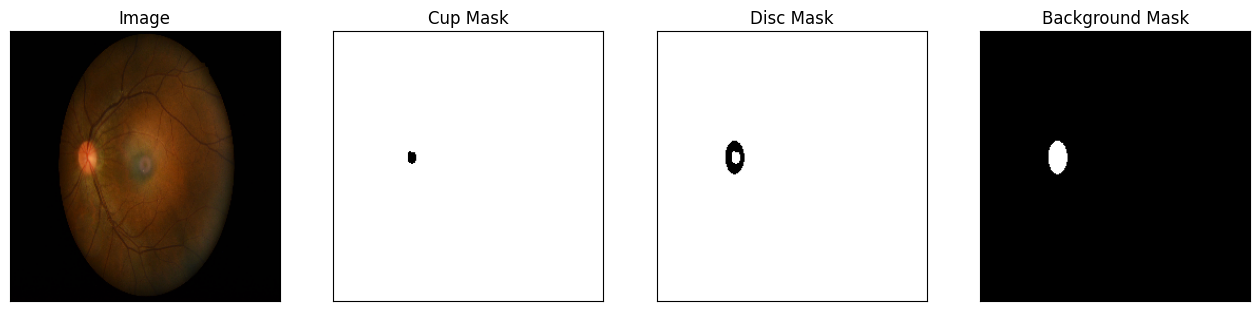

In [ ]:
# Lets look at data we have
#dataset = Dataset(x_valid_dir, y_valid_dir, classes=['cup', 'disk'])
import random
# Dataset for train images
dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=['cup', 'disc'],#gamma
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

image, mask = dataset[random.randint(0, len(dataset)-1)] # get some sample

# GAMMA
visualize(
    image=image,
    cup_mask=mask[..., 0].squeeze(),
    disc_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Treinamento e avaliação dos modelos

In [ ]:
LR=0.0001
EPOCHS = 40
early_stop_epochs = 25
BACKBONE = "resnet50"
preprocess_input = sm.get_preprocessing(BACKBONE)
model_classes=['cup', 'disc']#gamma

In [ ]:
# define network parameters
n_classes = 1 if len(model_classes) == 1 else (len(model_classes) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
optim = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss()#sem class weights
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, loss=total_loss, metrics=metrics)

In [ ]:
# Dataset for train images
BATCH_SIZE=1

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=model_classes,
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=model_classes,
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, img_size, img_size, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, img_size, img_size, n_classes)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=model_classes,
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
  )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

#define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True,save_best_only=True, mode='min',verbose=1),

#     #keras.callbacks.ReduceLROnPlateau(),
# ]

dir_save_dataset = '/content/Modelos Treinados'
if not Path(dir_save_dataset).is_dir():
  os.mkdir(dir_save_dataset)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs, verbose=1, mode='auto'),
    tf.keras.callbacks.ModelCheckpoint(filepath=  dir_save_dataset + '/' + BACKBONE + '_best_model.weights.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, mode='min',verbose=1),
    #keras.callbacks.ReduceLROnPlateau(),
]

[0, 1]
[0, 1]
[0, 1]


In [ ]:
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - f1-score: 0.1940 - iou_score: 0.1266 - loss: 0.8444
Epoch 1: val_loss improved from inf to 0.73635, saving model to /content/Modelos Treinados/resnet50_best_model.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 57s 138ms/step - f1-score: 0.1960 - iou_score: 0.1283 - loss: 0.8438 - val_f1-score: 0.2697 - val_iou_score: 0.2265 - val_loss: 0.7364
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - f1-score: 0.6972 - iou_score: 0.5852 - loss: 0.7215
Epoch 2: val_loss did not improve from 0.73635
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - f1-score: 0.6973 - iou_score: 0.5855 - loss: 0.7213 - val_f1-score: 0.3103 - val_iou_score: 0.2903 - val_loss: 0.7403
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - f1-score: 0.7986 - iou_score: 0.7007 - loss: 0.6733
Epoch 3: val_loss did not improve from 0.73635
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - f1-score: 0.7985 - iou_score: 0.7007 - loss: 0.6732 - val_f1-score: 0.2626 - val_iou_score: 0.2176 - val_loss: 0.754

In [ ]:
def analisa_mask (mask_pred):
  # Suponha que sua máscara predita seja chamada mask_pred (ex: shape [1, 256, 256, 3])
  mask = np.squeeze(mask_pred)  # Remove dimensão de batch

  # Se for uma máscara com classes codificadas como one-hot (shape [256, 256, 3]):
  if mask.ndim == 3 and mask.shape[-1] == 3:
      print('a')
      mask_classes = np.argmax(mask, axis=-1)
  else:
      print('b')
      mask_classes = mask  # Caso já esteja em 2D

  # Ver os valores únicos presentes (ex: [0, 1, 2])
  print("Classes presentes na máscara:", np.unique(mask_classes))

In [ ]:
def save_mask(output_path, mask_pred):
  # Suponha que sua predição seja: mask_pred (shape: [1, 256, 256, 3])
  # 1. Remove dimensão do batch
  mask = np.squeeze(mask_pred, axis=0)  # shape: (256, 256, 3)

  # 2. Converte one-hot encoding em classes (0 = fundo, 1 = disco, 2 = copo)
  mask_class = np.argmax(mask, axis=-1).astype(np.uint8)  # shape: (256, 256)

  # 3. Mapeia classes para tons usados no treinamento:
  # fundo (0) -> branco (255), disco (1) -> preto (0), copo (2) -> cinza (128)
  visual_mask = np.zeros_like(mask_class, dtype=np.uint8)
  visual_mask[mask_class == 0] = 128 #Copo
  visual_mask[mask_class == 1] = 0 #Disco
  visual_mask[mask_class == 2] = 255 #Fundo

  # 4. Define o caminho de saída
  # output_dir = 'mascaras_salvas'
  # os.makedirs(output_dir, exist_ok=True)
  # output_path = os.path.join(output_dir, 'mascara_predita_001.png')

  # 5. Salva a imagem
  cv2.imwrite(output_path, visual_mask)

  print(f"Máscara salva em: {output_path}")


In [ ]:
test_files = sorted([f for f in os.listdir(x_test_dir) if os.path.isfile(os.path.join(x_test_dir, f))])
gamma_masks_save = '/content/Masks Generateds/'
if not os.path.exists(gamma_masks_save):
  os.mkdir(gamma_masks_save)

def create_masks(model, test_dataset, gamma_masks_save, test_files):
    masks = []
    #for batch in test_dataloader:
    for i in range(len(test_dataset)):
        images, true_masks = test_dataset[i]
        images = np.expand_dims(images, axis=0)
        predicted_mask = model.predict(images)
        analisa_mask(predicted_mask)
        #predicted_mask = (predicted_mask * 255).astype(np.uint8)
        #predicted_mask = np.squeeze(predicted_mask, axis=0)  # shape vira (256, 256, 3)

        output_path = os.path.join(gamma_masks_save, test_files[i])
        save_mask(output_path, predicted_mask)

    #     visualize(
    #     images=denormalize(images.squeeze()),
    #     #image = (image.squeeze()/255.0).astype("float32"),
    #     #gt_mask=gt_mask.squeeze(),
    #     pr_mask=predicted_mask.squeeze(),
    # )
        #masks.append((predicted_masks, true_masks))
    #return masks

# Criar máscaras para o conjunto de teste
test_masks = create_masks(model, test_dataset, gamma_masks_save, test_files)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
a
Classes presentes na máscara: [0 1 2]
Máscara salva em: /content/Masks Generateds/0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
a
Classes presentes na máscara: [0 1 2]
Máscara salva em: /content/Masks Generateds/0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
a
Classes presentes na máscara: [0 1 2]
Máscara salva em: /content/Masks Generateds/0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
a
Classes presentes na máscara: [0 1 2]
Máscara salva em: /content/Masks Generateds/0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
a
Classes presentes na máscara: [0 1 2]
Máscara salva em: /content/Masks Generateds/0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
a
Classes presentes na máscara: [0 1 2]
Máscara salva em: /content/Masks Generateds/0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
a
Classes presentes na máscara: [0 1 2]
Máscara salva em: /content/Masks Generateds/0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
a
Classes presentes na máscara: [0 1 2]
Másca